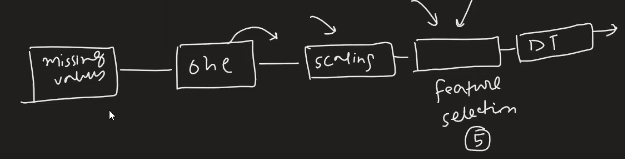

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Let's Plan

In [5]:
df.drop(columns=['PassengerId','Name','Ticket','Cabin'],inplace=True)

In [6]:
# Step 1 -> train/test/split
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['Survived']),
                                                 df['Survived'],
                                                 test_size=0.2,
                                                random_state=42)

In [7]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,male,45.5,0,0,28.5000,S
733,2,male,23.0,0,0,13.0000,S
382,3,male,32.0,0,0,7.9250,S
704,3,male,26.0,1,0,7.8542,S
813,3,female,6.0,4,2,31.2750,S


In [8]:
y_train.sample(5)

,Survived
787,0
75,0
759,1
429,1
223,0


In [9]:
# imputation transformer
trf1 = ColumnTransformer([
    ('impute_age',SimpleImputer(),[2]),
    ('impute_embarked',SimpleImputer(strategy='most_frequent'),[6])
],remainder='passthrough')


In [10]:
# one hot encoding
trf2 = ColumnTransformer([
    ('ohe_sex_embarked',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),[1,6])
],remainder='passthrough')

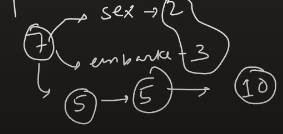

In [11]:

# Scaling  (0, 10)->not use drop='first'
trf3 = ColumnTransformer([
    ('scale',MinMaxScaler(),slice(0,10))
])


In [12]:
# Feature selection
trf4 = SelectKBest(score_func=chi2,k=8)

In [13]:
# train the model
trf5 = DecisionTreeClassifier()

# Create Pipeline

In [14]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3),
    ('trf4',trf4),
    ('trf5',trf5)
])

# Pipeline Vs make_pipeline

Pipeline requires naming of steps, make_pipeline does not.

(Same applies to ColumnTransformer vs make_column_transformer)

In [15]:
# Alternate Syntax
# pipe = make_pipeline(trf1,trf2,trf3,trf4,trf5)

In [16]:
# train
pipe.fit(X_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  [2]),
                                                 ('impute_embarked',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [6])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_sex_embarked',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [1, 6])])),
                ('trf3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 10, None))])),
                ('trf4',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x7bb5b9d8cb80>)),
                ('trf5', DecisionTreeClassifier())])

# Explore the Pipeline

In [17]:
# Code here
pipe.named_steps

{'trf1': ColumnTransformer(remainder='passthrough',
                   transformers=[('impute_age', SimpleImputer(), [2]),
                                 ('impute_embarked',
                                  SimpleImputer(strategy='most_frequent'),
                                  [6])]),
 'trf2': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe_sex_embarked',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  [1, 6])]),
 'trf3': ColumnTransformer(transformers=[('scale', MinMaxScaler(), slice(0, 10, None))]),
 'trf4': SelectKBest(k=8, score_func=<function chi2 at 0x7bb5b9d8cb80>),
 'trf5': DecisionTreeClassifier()}

In [18]:
pipe.named_steps['trf1']

ColumnTransformer(remainder='passthrough',
                  transformers=[('impute_age', SimpleImputer(), [2]),
                                ('impute_embarked',
                                 SimpleImputer(strategy='most_frequent'),
                                 [6])])

In [19]:
pipe.named_steps['trf1'].transformers_

[('impute_age', SimpleImputer(), [2]),
 ('impute_embarked', SimpleImputer(strategy='most_frequent'), [6]),
 ('remainder',
  FunctionTransformer(accept_sparse=True, check_inverse=False,
                      feature_names_out='one-to-one'),
  [0, 1, 3, 4, 5])]

In [20]:
pipe.named_steps['trf1'].transformers_[0]

('impute_age', SimpleImputer(), [2])

In [21]:
pipe.named_steps['trf1'].transformers_[0][1]

SimpleImputer()

In [22]:
pipe.named_steps['trf1'].transformers_[0][1].statistics_

array([29.49884615])

In [23]:
pipe.named_steps['trf1'].transformers_[1][1].statistics_

array(['S'], dtype=object)

In [24]:
# Display Pipeline

from sklearn import set_config
set_config(display='diagram')

In [25]:
# Predict
y_pred = pipe.predict(X_test)

In [26]:
y_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0])

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6256983240223464

# Cross Validation using Pipeline

In [28]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

np.float64(0.6391214419383433)

# GridSearch using Pipeline

In [29]:
# gridsearchcv
params = {
    'trf5__max_depth':[1,2,3,4,5,None]
}

In [30]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('impute_age',
                                                                         SimpleImputer(),
                                                                         [2]),
                                                                        ('impute_embarked',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         [6])])),
                                       ('trf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe_sex_embarked',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         [1,
                                                                          6])])),
                                       ('trf3',
                                        ColumnTransformer(transformers=[('scale',
                                                                         MinMaxScaler(),
                                                                         slice(0, 10, None))])),
                                       ('trf4',
                                        SelectKBest(k=8,
                                                    score_func=<function chi2 at 0x7bb5b9d8cb80>)),
                                       ('trf5', DecisionTreeClassifier())]),
             param_grid={'trf5__max_depth': [1, 2, 3, 4, 5, None]},
             scoring='accuracy')

In [31]:
grid.best_score_

np.float64(0.6391214419383433)

In [32]:
grid.best_params_

{'trf5__max_depth': 2}

# Exporting the Pipeline

In [33]:
# export
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))